In [744]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

### Data load and preprocessing

In [745]:
df = pd.read_csv('dataset/AI_Companies.csv')

In [746]:
df.drop(axis=1, index=2261, inplace=True)
df.reset_index(inplace=True)

In [747]:
df = df.iloc[:,:-1]
df = df.drop_duplicates()
df = df.dropna()
df.sample(5)

,index,Company_Name,Website,Location,Minimum Project Size,Average Hourly Rate,Number of Employees,Percent AI Service Focus
2217,2217,Interlancompu,https://interlan.ai/,"Quito, Ecuador",Undisclosed,Undisclosed,10 - 49,20%
1865,1865,TIZBI,https://tizbi.com,"Raleigh, NC","$50,000+",$25 - $49 / hr,50 - 249,15%
815,815,NanopreciseSciCorp,https://nanoprecise.io/,"Edmonton, Canada",Undisclosed,Undisclosed,50 - 249,50%
1171,1171,iLeafSolutionsPvt.Ltd.,http://ileafsolutions.com,"Kochi, India","$5,000+",< $25 / hr,50 - 249,10%
783,783,Presagen,https://www.presagen.com/,"Adelaide, Australia",Undisclosed,Undisclosed,2 - 9,100%


In [748]:
loc_split = df['Location'].str.split(pat=", ")
sizes = loc_split.apply(lambda x: len(x))
drop_mask = sizes > 2
loc_split = loc_split[~drop_mask]
new_df = df[~drop_mask]
sizes = sizes[~drop_mask]
new_df = new_df.loc[sizes.le(2)].copy()
new_split = loc_split.loc[new_df.index]
new_df['Country'] = new_split.str[-1].str.strip()
new_df['City']    = np.where(new_split.str.len().eq(2),
                             new_split.str[0].str.strip(), pd.NA)
new_df.drop(columns=['Location'], inplace=True)
new_df.reset_index(inplace=True, drop=True)
new_df['Country'] = new_df['Country'].apply(lambda x: x if len(x) > 2 else 'USA')

In [749]:
new_df['Minimum Project Size'].unique()

array(['Undisclosed', '$100,000+', '$1,000+', '$10,000+', '$50,000+',
       '$5,000+', '$25,000+', '$75,000+', '$250,000+'], dtype=object)

In [750]:
def parse_avg(x):
    if pd.isna(x) or x in ['Undisclosed', 'Freelancer']:
        return None
    nums = [''.join(c for c in i if c.isdigit()) for i in x.split('-')]
    if not nums:
        return pd.NA
    vals = list(map(float, nums))
    return round(sum(vals) / len(vals)+.5)

In [751]:
new_df['Minimum Project Size'] = (
    new_df['Minimum Project Size']
      .apply(parse_avg)
      .astype(float)
)

new_df['Average Hourly Rate'] = (
    new_df['Average Hourly Rate']
      .apply(parse_avg)
      .astype(float)
)

new_df['Number of Employees'] = (
    new_df['Number of Employees']
      .apply(parse_avg)
      .astype(float)
)

new_df['Percent AI Service Focus'] = (
    new_df['Percent AI Service Focus']
      .apply(parse_avg)
      .astype(float)
)

new_df

,index,Company_Name,Website,Minimum Project Size,Average Hourly Rate,Number of Employees,Percent AI Service Focus,Country,City
0,0,Smith.ai,https://smith.ai/,NaN,NaN,625.0,10.0,USA,Los Altos
1,1,MooveIt,https://moove-it.com/,100000.0,75.0,150.0,16.0,USA,Austin
2,2,TechSpeedInc,http://www.techspeed.com/,1000.0,26.0,150.0,40.0,USA,Portland
3,3,WillDom,https://willdom.com/,10000.0,75.0,625.0,10.0,USA,Fort Lauderdale
4,4,Icreon,https://www.icreon.com/en,50000.0,125.0,625.0,10.0,USA,New York
...,...,...,...,...,...,...,...,...,...
3076,3095,HurekaTechnologiesInc,http://www.hurekatek.com,10000.0,38.0,30.0,20.0,USA,New Brunswick
3077,3096,MYZEALI.T.SolutionsLLC,http://www.myzealit.com/,10000.0,38.0,625.0,10.0,USA,Los Angeles
3078,3097,Intelia,https://intelia.io/,25000.0,NaN,30.0,20.0,Nigeria,Lagos
3079,3098,MojoTrek,http://www.mojotrek.com,10000.0,75.0,30.0,26.0,USA,Chicago


### Data exploration/visualization

In [752]:
country_counts = new_df.groupby('Country')['Country'].value_counts().sort_values()

<BarContainer object of 20 artists>

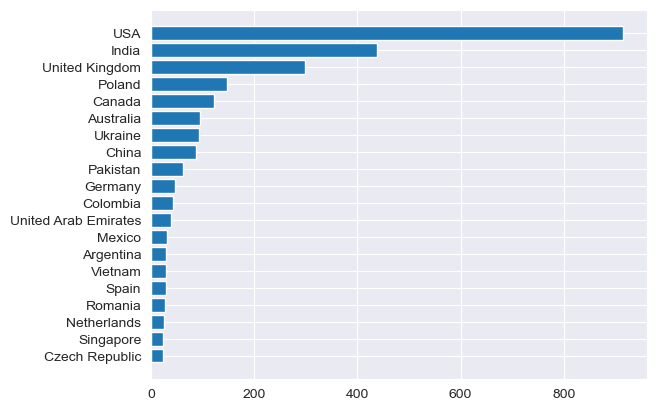

In [753]:
plt.barh(country_counts.index[-20:], country_counts[-20:])

In [754]:
scaled_df = pd.DataFrame(new_df, columns=["Company_Name","Country","Minimum Project Size"])
mask = scaled_df['Minimum Project Size'] >= 50000
scaled_df = scaled_df.loc[mask]

fig = px.treemap(
    scaled_df,
    path=["Country","Company_Name"],
    values="Minimum Project Size",
    hover_data={"Minimum Project Size":":.1f", "Country":True, "Company_Name":True},
    width=1800,
    height=1000
)

fig.update_traces(
    textposition="middle center",
    hovertemplate="<b>%{label}</b><br>Value: $%{value:.0f}+<extra></extra>",
    texttemplate="%{label}<br>$%{value:.0f}+",
    textinfo="label+value"
)

fig.update_layout(
    title="Country and its companies (with 50000+ minimal budget for client)",
    margin=dict(l=10,r=10,t=60,b=10),
)

fig.show()

In [761]:
fig = px.scatter_3d(
    new_df,
    x="Minimum Project Size",
    y="Average Hourly Rate",
    z="Number of Employees",
    color="Country",
    hover_name="Company_Name",
    title="3D Scatter: Minimal Project Budget vs Hourly Rate vs Number of Employees",
    width=1800,
    height=1000,

)

fig.update_layout(
    margin=dict(l=30,r=30,t=100,b=10),
)

fig.show()